+ 在线book：<https://zh-v2.d2l.ai/chapter_multilayer-perceptrons/kaggle-house-price.html>
+ jupyter对应的slides:<http://courses.d2l.ai/zh-v2/assets/notebooks/chapter_multilayer-perceptrons/kaggle-house-price.slides.html#/>


数据集介绍，来自在线book：
> 房价预测比赛是一个很好的起点。这个数据是相当通用的，不会需要使用带特殊结构的模型（就像音频或视频可能需要的那样）。此数据集由Bart de Cock于2011年收集 [DeCock, 2011] ，涵盖了2006-2010年期间亚利桑那州埃姆斯市的房价。它比哈里森和鲁宾菲尔德（1978年）的波士顿房价数据集要大得多，也有更多的特征。


+ 数据集出自的论文：<http://jse.amstat.org/v19n3/decock.pdf>
+ kaggle比赛地址：<https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview>

实现几个函数，来方便下载数据

# 代码

## 下载数据

In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB=dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

下面关于assert的语法，参考菜鸟教程：<https://www.runoob.com/python3/python3-assert.html>
```python
>>> assert 1==2, '1 不等于 2'
Traceback (most recent call last):
  File "<stdin>", line 1, in <module>
AssertionError: 1 不等于 2
>>>
```

另外，李沐老师团队会维护一个DATA_HUB字典，其将
+ 数据集名称的字符串映射到数据集相关的二元组上，
+ 这个二元组包含数据集的url和验证文件完整性的sha-1密钥。

所有这样的数据集都托管在地址为DATA_URL的站点上。

+ download函数用来下载数据集，将数据集缓存在本地目录（默认情况下为../data）中，并返回下载文件的名称。、
+ 如果缓存目录中已经存在此数据集文件，并且其sha-1与存储在DATA_HUB中的相匹配，我们将使用缓存的文件，以避免重复的下载。

In [6]:
def download(name,cache_dir=os.path.join("..","data")):
    """
    下载一个DATA_HUB中的文件，返回本地文件名
    """
    assert name in DATA_HUB,f"{name}不存在于{DATA_HUB}."
    url,sha1_hash=DATA_HUB[name]
    os.makedirs(cache_dir,exist_ok=True)
    fname=os.path.join(cache_dir,url.split("/")[-1])
    if os.path.exists(fname):
        sha1=hashlib.sha1()
        with open(fname,'rb') as f:
            while True:
                data=f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest()==sha1_hash:
            return fname
    print(f"正在从{url}下载{fname}...")
    r=requests.get(url,stream=True,verify=True)
    with open(fname,'wb') as f:
        f.write(r.content)
    return fname

+ 将文件名和后缀分离，有现成的函数`os.path.splitext(fname)`

+ 这个函数的说明：
> Split the extension from a pathname.
Extension is everything from the last dot to the end, ignoring
leading dots.  Returns "(root, ext)"; ext may be empty.

从路径中分离后缀，最后一个点号到最后就是扩展，忽略其余前面的，返回（文件名，ext），后缀可能为空

In [7]:
def download_extract(name,folder=None):
    """
    下载并解压zip/tar文件  如果不指定folder 默认就使用文件的名称作为存放文件夹
    无法指定base_dir,就是../data
    """
    fname=download(name)
    base_dir=os.path.dirname(fname)
    data_dir,ext=os.path.splitext(fname)
    if ext=='.zip':
        fp=zipfile.ZipFile(fname,'r')
    elif ext in ('.tar','.gz'):
        fp=tarfile.open(fname,'r')
    else:
        assert False,"只有zip/tar文件才可以被解压缩"
    fp.extractall(base_dir)
    return os.path.join(base_dir,folder) if folder else data_dir

def download_all():
    """
    下载DATA_HUB中所有文件
    """
    for name in DATA_HUB:
        download(name)

使用pandas读入并处理数据

In [8]:
%matplotlib inline
import numpy as np
import pandas as pd

import torch
from torch import nn
import d2l_torch as d2l

下载的数据放在 当前jupyer文件的上层目录的data文件夹中。

In [9]:
DATA_HUB['kaggle_house_train'] = (DATA_URL + 'kaggle_house_pred_train.csv','585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (DATA_URL + 'kaggle_house_pred_test.csv','fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


这里可以看到，
+ 训练集是1460个样本，有81列值（包含label，也就是房价）
+ 测试集是1459个样本，有80列值（没有房价这个label）

正常都是可以下载的，我报错是因为DATA_URL最后写错了，`.com`写成了`/com`，所以对于自己不熟悉的代码，尤其是网络下载这种，直接复制，不好找错误。。。

## 数据处理

> 注意，下面在进行处理的时候，测试集和训练集是一起做处理的。。所以按照严格的标准来说，已经发生了一部分数据泄漏了，因为缩放的时候是整体进行缩放变为零均值，同时填充也是零均值。


> 但是打比赛，就可以这样操作，训练的时候还是只使用训练集，但是一起处理好，测试的时候就比较快。。。

稍微看一下数据情况

In [10]:
train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


+ 由于每个样本中，第一个特征都是ID，所以需要删掉（其实读入的时候就可以删掉）
+ 另外，由于训练数据有标签，所以要得到所有特征，其实可以把训练集的标签也去掉

In [11]:
all_features=pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))

In [12]:
all_features.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


进行缺失值处理，将所有缺失的值替换为响应特征的均值
+ 均值填充
+ 将特征缩放到零均值和单位方差，来标准化数据

+ 可以看看每类数据的物理意义，还有数据范围，可以看到，不同列数据的数据范围数量级差距还是比较大！有1\~10的，也有1w\~21w的，0~508的

### 数值类型的数据处理

In [13]:
numeric_features=all_features.dtypes[all_features.dtypes!='object'].index

In [14]:
numeric_features[:10]

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2'],
      dtype='object')

In [15]:
type(all_features.dtypes),set(all_features.dtypes.tolist())

(pandas.core.series.Series, {dtype('int64'), dtype('float64'), dtype('O')})

所以得到数据中，数据类型为数值的，简单判断的话，只要不是object就是数值类型了。。

关于dataframe的dtypes类型预测，参考：
+ https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html
+ https://pandas.pydata.org/pandas-docs/stable/user_guide/basics.html#basics-dtypes

In [16]:
all_features[numeric_features]=all_features[numeric_features].apply(
    lambda x:(x-x.mean())/x.std())

因为已经使用零均值进行过缩放了，所以直接用0作为均值填补的数字就可以了。把一个分布转为均值为0，方差为1的标准正态分布，就是减去均值除以方差。。。就像下面这个图

![img](https://iknow-pic.cdn.bcebos.com/aec379310a55b3194309f41453a98226cefc17da)

In [17]:
all_features[numeric_features]=all_features[numeric_features].fillna(0)

### 文本类型/离散值的数据处理

In [18]:
not_numeric_features=all_features.dtypes[all_features.dtypes=='object'].index

In [19]:
not_numeric_features.shape

(43,)

所以80列数据里，除了第一列是id，可用的特征一共其实是79个，其中有43个都是非数值类型的。。。

In [20]:
all_features=pd.get_dummies(all_features,dummy_na=True)
all_features.shape

(2919, 331)

1460+1459=2919行，列的话，之前是79列，其中79-43=36列是数值，也就是剩下的43列经过one_hot编码之后变成了331-36=295。。。

可以稍微查看一下变换后的样子

In [21]:
not_numeric_features[-1]

'SaleCondition'

In [22]:
all_features.iloc[:5,-8:]

,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0


对比一下变化之前的这个SaleCondition,可以看到，确实离散值只有这些。。。6个，加上如果是缺失值会有一列是nan，一共就是7列。其他离散数据也是这种形式。。

In [23]:
set(train_data.iloc[:,-2])

{'Abnorml', 'AdjLand', 'Alloca', 'Family', 'Normal', 'Partial'}

关于get_dummies函数
> Convert categorical variable into dummy/indicator variables.

```python
--------
>>> s = pd.Series(list('abca'))

>>> pd.get_dummies(s)
   a  b  c
0  1  0  0
1  0  1  0
2  0  0  1
3  1  0  0

>>> s1 = ['a', 'b', np.nan]

>>> pd.get_dummies(s1)
   a  b
0  1  0
1  0  1
2  0  0

>>> pd.get_dummies(s1, dummy_na=True)
   a  b  NaN
0  1  0    0
1  0  1    0
2  0  0    1
```

### pandas→numpy→torch

+ 从pandas格式中提取numpy格式，并将其转换为张量表示
+ numpy默认float是64，这里转换到torch变成32

In [41]:
n_train=train_data.shape[0]
# 获取训练集的样本个数，训练还是只会使用训练集，提前一起处理测试集就是为了方便
train_features=torch.tensor(all_features[:n_train].values,dtype=torch.float32)
# 这里没有用float16，而是32哎
test_features=torch.tensor(all_features[n_train:].values,dtype=torch.float32)

# 标签是房价，这个数值没有缩放过
train_labels=torch.tensor(train_data.SalePrice.values.reshape(-1,1),dtype=torch.float32)

In [25]:
train_data.SalePrice.values[:2]

array([208500, 181500], dtype=int64)

In [26]:
train_labels[:2]

tensor([[208500.],
        [181500.]])

原先的标签和变换后的区别，就是后面每列是一个标签，前面搁在一起了

## 训练/模型

In [27]:
in_features=train_feature.shape[1]
in_features
# 输入的特征的维度

331

 这里不向之前的FASHION_MNIST数据集，是图像，需要flatten一下，这里就是一维的向量

### 网络

In [28]:
def get_net():
    net=nn.Sequential(nn.Linear(in_features,1))
    # 输入特征331，输出1维（预测的房价）
    return net

+ 另外，上面虽然有MSELoss，也就是(真实值-预测值)的平方，作为误差，
+ 但是在这个任务中，使用MSELoss不太合适，因为房价可能是100w，可能是20w，还可能是2w？？ 这样算下来，100w的房子误差就更大，小房子误差的权重就小。不好
+ 所以要使用一种相对误差来衡量,即使用价格预测的对数来衡量差异

+ $\frac{y-\hat{y}}{y} $是衡量相对误差的一种方式，但是其实也可以直接$\frac{\hat{y}}{y}$
+ 而且这里其实没有使用相对，而是直接利用ln减小了数据范围的差异，可以看到ln(x)增长是越来越慢的，所以值越大，被缩放的就越厉害，这样值的差距不会很大。

(**解决这个问题的一种方法是用价格预测的对数来衡量差异**)。事实上，这也是比赛中官方用来评价提交质量的误差指标。即将 $\delta$ for $|\log y - \log \hat{y}| \leq \delta$转换为$e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$。这使得预测价格的对数与真实标签价格的对数之间出现以下均方根误差：

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$


除法就可以加一个log变成减法了。所以通常对比较大的正值来做回归的时候，都会使用log函数。

+ 所以下面代码限制$\hat{y}$的值不能小于1，也是为了防止数字太小，导致计算不稳定

### 损失函数

In [29]:
loss=nn.MSELoss()

def log_rmse(net,features,labels):
    clipped_preds=torch.clamp(net(features),1,float('inf'))
    # 不会出现小于1的值，小于1的置1
    rmse=torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))
    # loss是有平方的，sqrt开方了
    return rmse.item()

关于其中的`clamp`函数，如下
```python
clamp(input, min, max, *, out=None) -> Tensor
Clamp all elements in :attr:`input` into the range `[` :attr:`min`, :attr:`max` `]` and return
a resulting tensor:
```

+ 简单来说，就是把输入限制在min和max之间，
+ 小于min就替换为min，大于max就替换为max，在这两个值之间的就返回值本身

![img](https://gimg2.baidu.com/image_search/src=http%3A%2F%2Finews.gtimg.com%2Fnewsapp_match%2F0%2F5364204980%2F0.jpg&refer=http%3A%2F%2Finews.gtimg.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=jpeg?sec=1638690924&t=1db4cce21630e4eee58d81554fe2dc43)

+ torch.log默认就是以e为底的，即ln(x)，图像如上
+ 所以可以看到，如果x<1，也就是上面的clamp限制后的clipped_preds，会被置为1
+ 这主要是为了在取对数时进一步稳定该值，将小于1的值设置为1

训练时使用的优化器是Adam

+ Adam可以认为是一个比较平滑的SGD
+ 最大的好处是对学习率不敏感

### train函数

In [30]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # L2正则，又叫岭回归或者权重衰退
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
            # 训练时候使用的损失函数是 log_rmse
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

### k折交叉验证

In [31]:
def get_k_fold_data(k, i, X, y):
    """
    k 几折，i是验证集对应的那个part
    每次返回一组，例如5折，第3部分是验证集，i=3，则返回X_trainXXX和X_valid，返回一组k折
    """
    assert k > 1
    fold_size = X.shape[0] // k # 整除 只要整数部分，不要余数
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        # X只要行，不管列，y的结构是[[123],[1234]] 只有行
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            # axis=1，在样本个数，行这个维度上进行合并
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

一些语句的解释

In [32]:
100//3,100/3

(33, 33.333333333333336)

简单来说，slice就是用来创建切片的那个序号/索引的，然后后面切片的时候直接用这个索引就好了

In [33]:
idx=slice(2,4)
# slice(stop)
# slice(start, stop[, step])
# Create a slice object.  This is used for extended slicing (e.g. a[0:10:2])
a=[1,2,3,4]
a[idx]

[3, 4]

代码写的看起来比较low，肯定不是高大上的方法，但是任务比较简单，就没别要写那么复杂

返回训练和验证误差的平均值
+ K折，比如5折，那么5个部分中每部分都要作为验证集跑一次，所以其实有五组数据，
+ 上面函数只是返回一组，所以下面函数调用上面函数计算整体跑5次的误差情况

In [34]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    """
    K 折交叉验证中训练 K 次后，返回训练和验证误差的平均值
    """
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        # 依次用0-4作为验证集进行返回
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        # train_ls是epoch中每个epoch的损失 [-1]表示取的是最后一个epoch
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

In [42]:
data = get_k_fold_data(5, 1, train_features, trainb_labels)

In [43]:
type(data)

tuple

关于`*data`中的'*'号，参考

+ [python中的函数参数前有*的问题](https://blog.csdn.net/Castlehe/article/details/121230054)
+ 总之记住一句话，加了星号（*）的变量名会存放所有未命名的变量参数
+ 所以*data就代替了get_k_fold_data函数返回的`return X_train, y_train, X_valid, y_valid`

### 开始训练

fold 1, train log rmse 0.170275, valid log rmse 0.156753
fold 2, train log rmse 0.162111, valid log rmse 0.189755
fold 3, train log rmse 0.164014, valid log rmse 0.168832
fold 4, train log rmse 0.168154, valid log rmse 0.154542
fold 5, train log rmse 0.163113, valid log rmse 0.182659
5-折验证: 平均训练log rmse: 0.165534, 平均验证log rmse: 0.170508


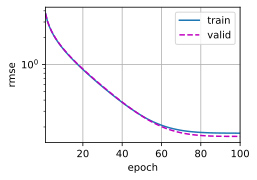

In [49]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, 'f'平均验证log rmse: {float(valid_l):f}')

### 学习率探讨

关于为什么学习率取这么大，
+ 猜测1：Adam对学习率不敏感？
    + 所以保持其他条件不变，将lr变为0.1，rmse很大，大约3.XXX，所以应该不是这个原因
+ 猜测2： 学习率小，所以其实可以看到曲线还一直在降低，
    + 所以令lr=0.1 ，加大num_epochs，多训练一些轮数，尝试了200,400之后，发现，rmse确实会降低。
    + num_epochs=400,rmse=1.693800
    + num_epochs=800,rmse=1.016245
    + num_epochs=1200,rmse=0.631207
    

得出结论，
+ lr太小了，所以收敛很慢，需要进行非常多轮的训练
+ 所以这里lr很大，是为了加速收敛。。。

fold 1, train log rmse 3.056331, valid log rmse 3.070584
fold 2, train log rmse 3.056443, valid log rmse 3.067451
fold 3, train log rmse 3.055156, valid log rmse 3.070339
fold 4, train log rmse 3.064178, valid log rmse 3.039971
fold 5, train log rmse 3.058184, valid log rmse 3.061487
5-折验证: 平均训练log rmse: 3.058058, 平均验证log rmse: 3.061966


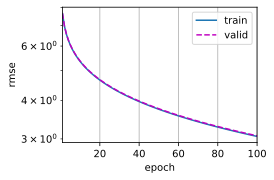

In [50]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.1, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, 'f'平均验证log rmse: {float(valid_l):f}')

fold 1, train log rmse 1.688473, valid log rmse 1.701221
fold 2, train log rmse 1.688491, valid log rmse 1.700038
fold 3, train log rmse 1.687454, valid log rmse 1.702807
fold 4, train log rmse 1.696038, valid log rmse 1.671341
fold 5, train log rmse 1.690053, valid log rmse 1.693593
5-折验证: 平均训练log rmse: 1.690102, 平均验证log rmse: 1.693800


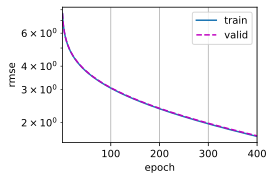

In [52]:
k, num_epochs, lr, weight_decay, batch_size = 5, 400, 0.1, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, 'f'平均验证log rmse: {float(valid_l):f}')

fold 1, train log rmse 0.627327, valid log rmse 0.635061
fold 2, train log rmse 0.625950, valid log rmse 0.640292
fold 3, train log rmse 0.625200, valid log rmse 0.640837
fold 4, train log rmse 0.632946, valid log rmse 0.607216
fold 5, train log rmse 0.627564, valid log rmse 0.632630
5-折验证: 平均训练log rmse: 0.627797, 平均验证log rmse: 0.631207


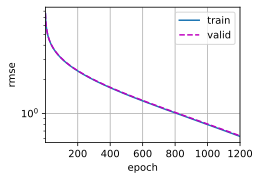

In [54]:
k, num_epochs, lr, weight_decay, batch_size = 5, 1200, 0.1, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, 'f'平均验证log rmse: {float(valid_l):f}')

### 提交你的kaggle预测

经过对上面修改网络结果，或者调参之后，把自己得到的参数放到下面，做预测，然后把结果保存到csv文件里，然后提交到kaggle上。

In [ ]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

# 数据切片

In [ ]:
5850*2

In [ ]:
a=[1,2,3,4]
a[0:4].extend(a[-3:0])
a

In [ ]:
a[::-1],a[-1],a[0:-1],a[-4:-1],a[-4:]

In [ ]:
a[1:]

In [ ]:
a[1:-1]